## ***Question 2, HW6***

In [1]:
import kagglehub
path = kagglehub.dataset_download("meetnagadia/kvasir-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kvasir-dataset


### ***Import Required Libraries***

In [2]:
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
#-----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
#-----------------------
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch import optim
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

### ***Function To Preprocess the Data***

In [3]:
def process(image_path, save_dir, size=(96, 96)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(size, resample=Image.BILINEAR)
    img = np.array(img).astype(np.float32) / 255.0
    img = Image.fromarray((img * 255).astype(np.uint8))
    filename = os.path.basename(image_path)
    img.save(os.path.join(save_dir, filename))

### ***Preprocessing Normal & Polyp Data***

In [4]:
normal_folders = [
    "/kaggle/input/kvasir-dataset/kvasir-dataset/normal-cecum",
    "/kaggle/input/kvasir-dataset/kvasir-dataset/normal-pylorus",
    "/kaggle/input/kvasir-dataset/kvasir-dataset/normal-z-line"
]
polyp_folder = "/kaggle/input/kvasir-dataset/kvasir-dataset/polyps"

out_normal = "processed/normal/imgs"
out_polyp = "processed/polyp/imgs"

os.makedirs(out_normal, exist_ok=True)
os.makedirs(out_polyp, exist_ok=True)

for folder in normal_folders:
    for file_name in tqdm(os.listdir(folder)):
        process(os.path.join(folder, file_name), out_normal)

print("Processing polyp images...")
for file_name in tqdm(os.listdir(polyp_folder)):
    process(os.path.join(polyp_folder, file_name), out_polyp)

100%|██████████| 500/500 [00:13<00:00, 36.30it/s]


Processing polyp images...


100%|██████████| 500/500 [00:06<00:00, 76.89it/s]


### ***Visual Example After Preprocessing***

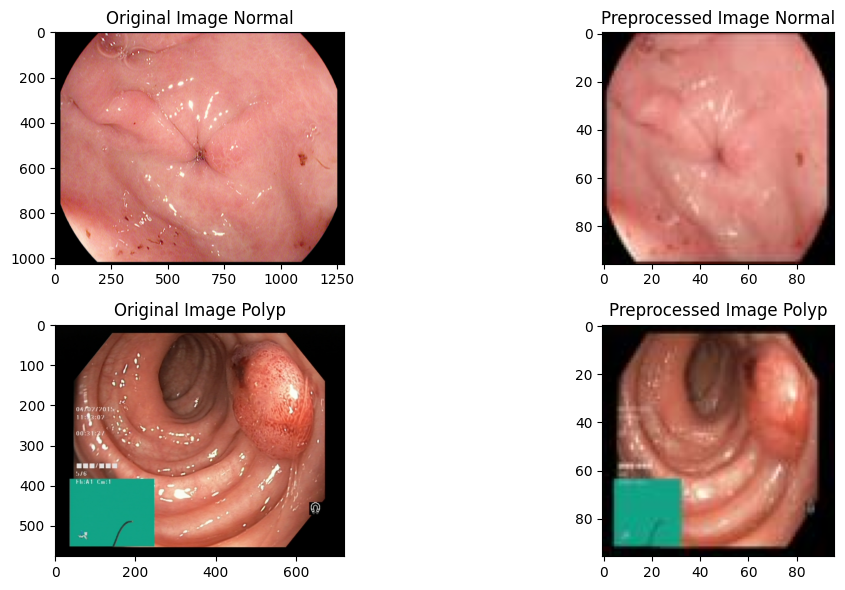

In [7]:
org_root = "/kaggle/input/kvasir-dataset/kvasir-dataset"
normal_image = os.listdir(org_root + "/normal-pylorus/")[random.randint(0, 100)]
polyp_image = os.listdir(org_root + "/polyps/")[random.randint(0, 100)]
preprocessed_root = "/content/processed/"

fix, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0][0].imshow(Image.open(org_root + "/normal-pylorus/" + normal_image))
axes[0][0].set_title("Original Image Normal")

axes[0][1].imshow(Image.open(preprocessed_root + "/normal/imgs/" + normal_image))
axes[0][1].set_title("Preprocessed Image Normal")

axes[1][0].imshow(Image.open(org_root + "/polyps/" + polyp_image))
axes[1][0].set_title("Original Image Polyp")

axes[1][1].imshow(Image.open(preprocessed_root + "/polyp/imgs/" + polyp_image))
axes[1][1].set_title("Preprocessed Image Polyp")

plt.tight_layout()
plt.show()

***

### ***Model Definition***

In [8]:
class EndoVAE(nn.Module):
    def __init__(self, latent_dim=6):
        super(EndoVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder based on the main article (not what it says in the exercise)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.encoder_flatten = nn.Flatten()
        self.encoder_hidden = nn.Linear(256*12*12, 256)
        self.mu = nn.Linear(256, latent_dim)
        self.encoder_logvar = nn.Linear(256, latent_dim)

        # Decoder based on the main article (not what it says in the exercise)
        self.fc_decoder = nn.Linear(latent_dim, 256*12*12)
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
          nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def encode(self, x):
        x = self.encoder(x)
        x = self.encoder_flatten(x)
        x = self.encoder_hidden(x)
        mu = self.mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(-1, 256, 12, 12)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

### ***Loss Definition***

In [ ]:
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def vae_loss(reconstruct, x, mu, logvar, beta=1.0):
    # r_loss = F.binary_cross_entropy(reconstruct, x, reduction='sum')
    r_loss = F.mse_loss(reconstruct, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return r_loss + beta * kl, r_loss, kl

***

### ***Training the Model (with normal data only)***

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolder(root='processed/normal', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EndoVAE(latent_dim=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 1000
loss_history = []
recon_history = []
kl_history = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    loss_history.append(epoch_loss)
    recon_history.append(epoch_recon)
    kl_history.append(epoch_kl)
    if epoch%100 == 0:
        print(f"Epoch {epoch} ---> total loss: {epoch_loss}")

Epoch 0 ---> total loss: 2913987.1875
Epoch 100 ---> total loss: 233903.7919921875
Epoch 200 ---> total loss: 179231.3056640625
Epoch 300 ---> total loss: 141307.0634765625
Epoch 400 ---> total loss: 162902.2734375
Epoch 500 ---> total loss: 121069.4775390625
Epoch 600 ---> total loss: 108968.580078125
Epoch 700 ---> total loss: 97723.49365234375
Epoch 800 ---> total loss: 95165.19921875
Epoch 900 ---> total loss: 108716.47607421875


### ***Loss During Training Plots***

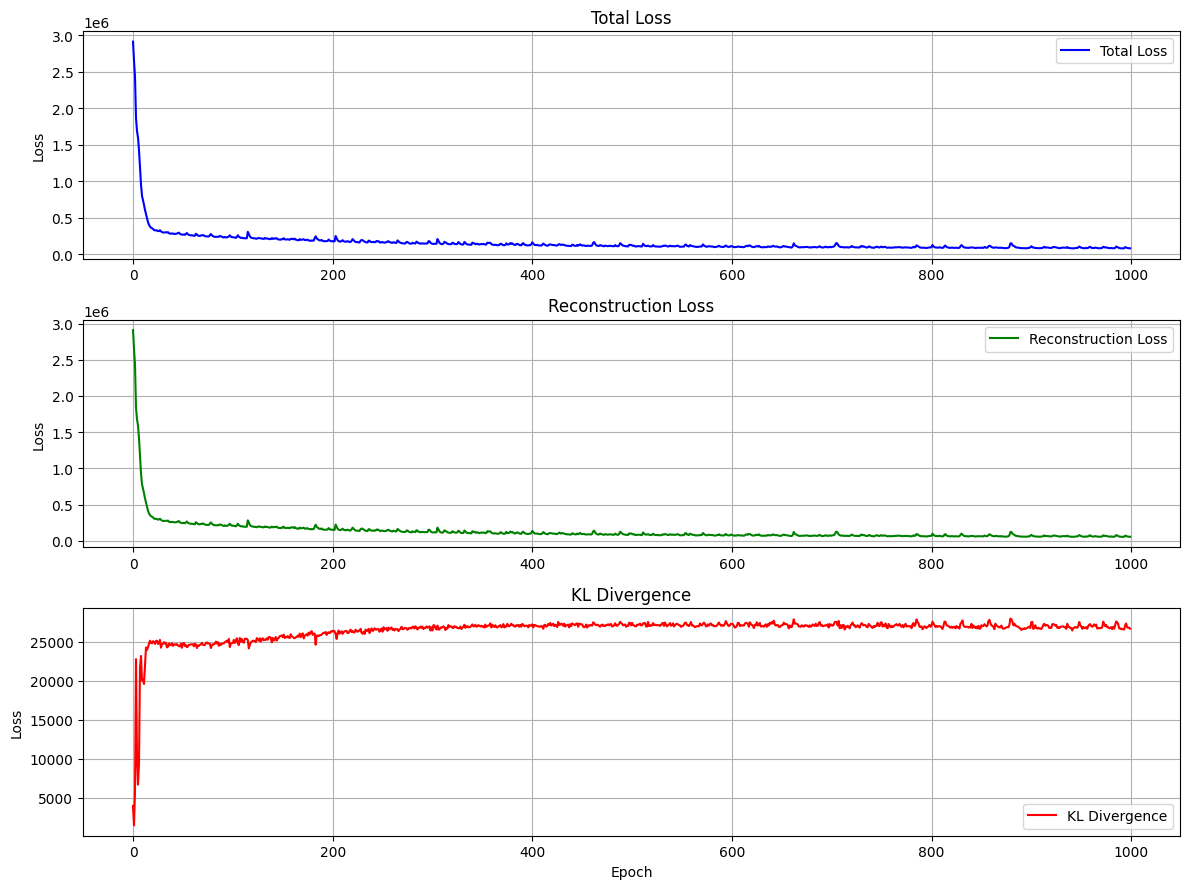

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9))

axs[0].plot(loss_history, label='Total Loss', color='blue')
axs[0].set_title('Total Loss')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(recon_history, label='Reconstruction Loss', color='green')
axs[1].set_title('Reconstruction Loss')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(kl_history, label='KL Divergence', color='red')
axs[2].set_title('KL Divergence')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


### ***Generating Random Images with the Model***

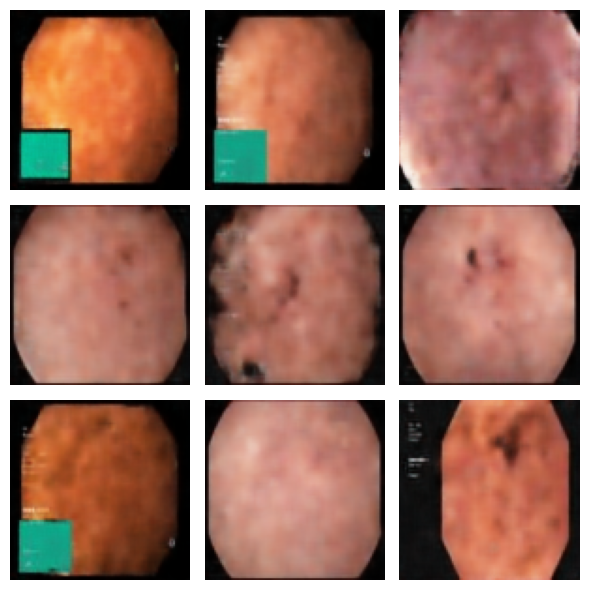

In [13]:
model.eval()
z = torch.randn(9, model.latent_dim).to(next(model.parameters()).device)
with torch.no_grad():
    generated = model.decode(z).cpu()
generated = generated.permute(0, 2, 3, 1)

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].imshow(generated[idx].numpy())
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

### ***Construct Some polyp Images with the Model***

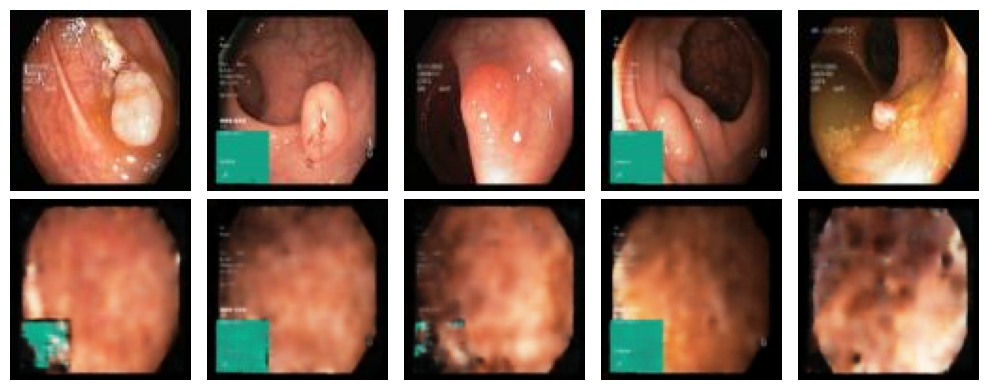

In [14]:
def reconstruct_images(model, image_paths):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    fig, axs = plt.subplots(2, len(image_paths), figsize=(len(image_paths) * 2, 4))
    for i, path in enumerate(image_paths):
        img = Image.open(path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            recon, _, _ = model(input_tensor)
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
        axs[1, i].imshow(recon.squeeze().permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')
    axs[0, 0].set_ylabel("Original")
    axs[1, 0].set_ylabel("Reconstructed")
    plt.tight_layout()
    plt.show()

polyp_paths = random.sample(os.listdir('/content/processed/polyp/imgs'), k=5)
for i in range(len(polyp_paths)):
    polyp_paths[i] = '/content/processed/polyp/imgs/' + polyp_paths[i]
reconstruct_images(model, polyp_paths)


### ***Evaluate the Model Using PSNR & SSIM***

In [15]:
def evaluate_on_polyp(model, paths):
    model.eval()
    transform = transforms.ToTensor()
    psnr_scores = []
    ssim_scores = []
    for path in paths:
        img = Image.open(path).convert('RGB')
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            reconstruct, _, _ = model(x)
        reconstruct = reconstruct.squeeze().permute(1, 2, 0).cpu().numpy()
        original = x.squeeze().permute(1, 2, 0).cpu().numpy()
        psnr_scores.append(psnr(original, reconstruct, data_range=1.0))
        ssim_scores.append(ssim(original, reconstruct, channel_axis=2, data_range=1.0))

    print(f"Average PSNR: {sum(psnr_scores)/len(psnr_scores)}")
    print(f"Average SSIM: {sum(ssim_scores)/len(ssim_scores)}")

polyp_paths = random.sample(os.listdir('/content/processed/polyp/imgs'), k=50)
for i in range(len(polyp_paths)):
    polyp_paths[i] = '/content/processed/polyp/imgs/' + polyp_paths[i]
evaluate_on_polyp(model, polyp_paths)


Average PSNR: 17.55911146918379
Average SSIM: 0.45497000217437744


***

### ***Training the Model Using Both Normal and Polyp data (not mentioned in the assignment, just for more information)***

In [16]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolder(root='processed', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EndoVAE(latent_dim=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 1000
loss_history = []
recon_history = []
kl_history = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    loss_history.append(epoch_loss)
    recon_history.append(epoch_recon)
    kl_history.append(epoch_kl)
    if epoch%100 == 0:
        print(f"Epoch {epoch} ---> total loss: {epoch_loss}")

Epoch 0 ---> total loss: 4429362.5625
Epoch 100 ---> total loss: 322723.8720703125
Epoch 200 ---> total loss: 204756.17578125
Epoch 300 ---> total loss: 164059.2021484375
Epoch 400 ---> total loss: 161754.30078125
Epoch 500 ---> total loss: 143676.86767578125
Epoch 600 ---> total loss: 125111.01513671875
Epoch 700 ---> total loss: 124520.12060546875
Epoch 800 ---> total loss: 165252.79345703125
Epoch 900 ---> total loss: 119245.96630859375


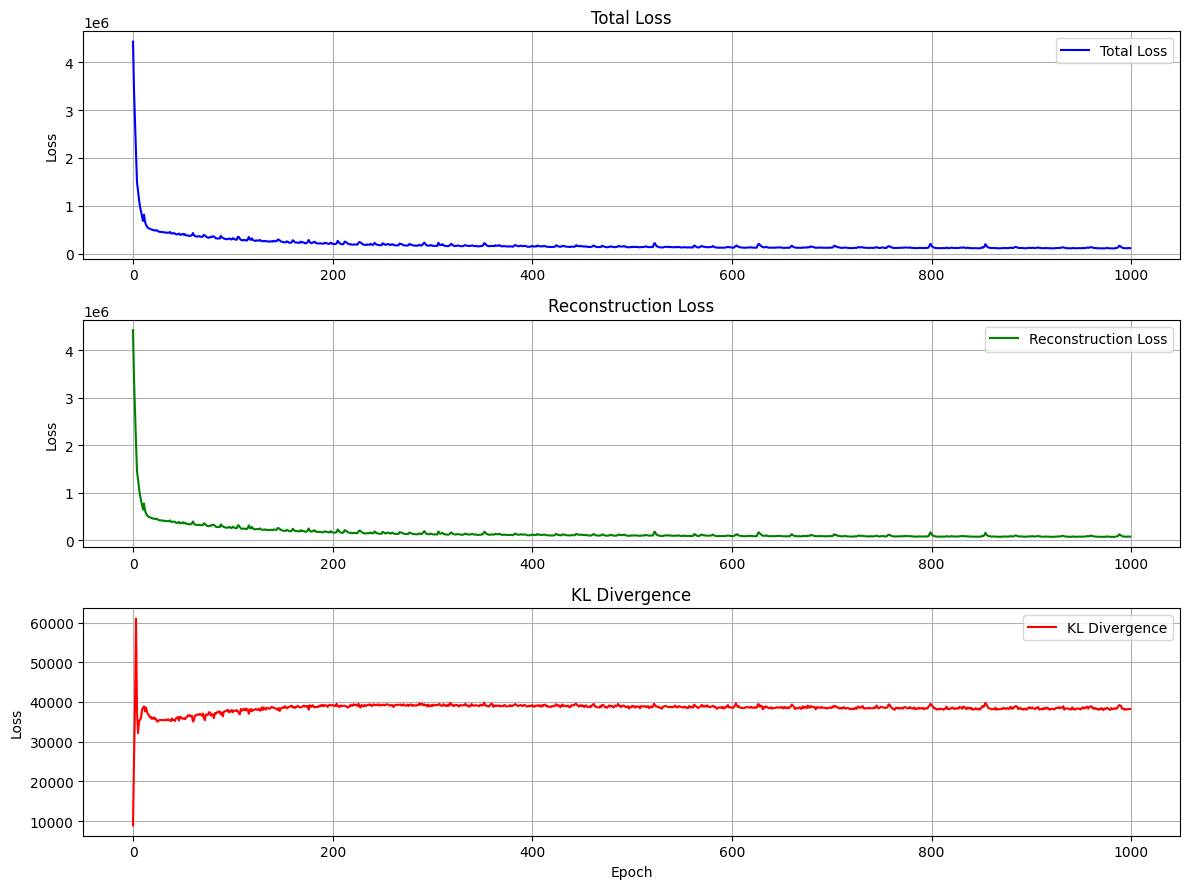

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9))

axs[0].plot(loss_history, label='Total Loss', color='blue')
axs[0].set_title('Total Loss')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(recon_history, label='Reconstruction Loss', color='green')
axs[1].set_title('Reconstruction Loss')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(kl_history, label='KL Divergence', color='red')
axs[2].set_title('KL Divergence')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


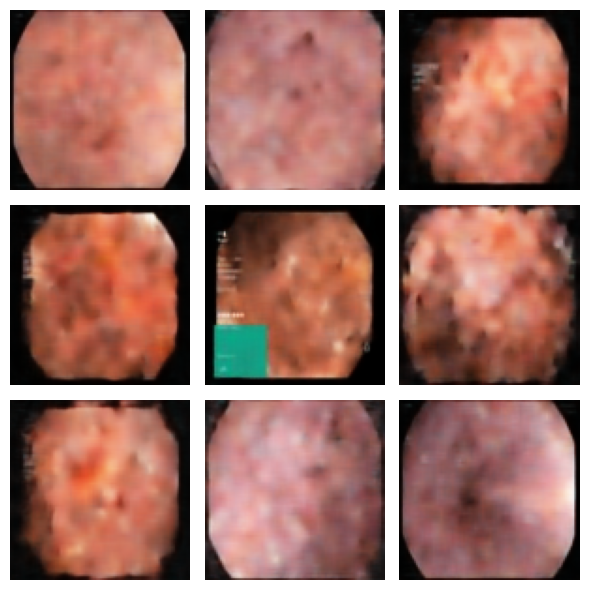

In [18]:
model.eval()
z = torch.randn(9, model.latent_dim).to(next(model.parameters()).device)
with torch.no_grad():
    generated = model.decode(z).cpu()
generated = generated.permute(0, 2, 3, 1)

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].imshow(generated[idx].numpy())
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

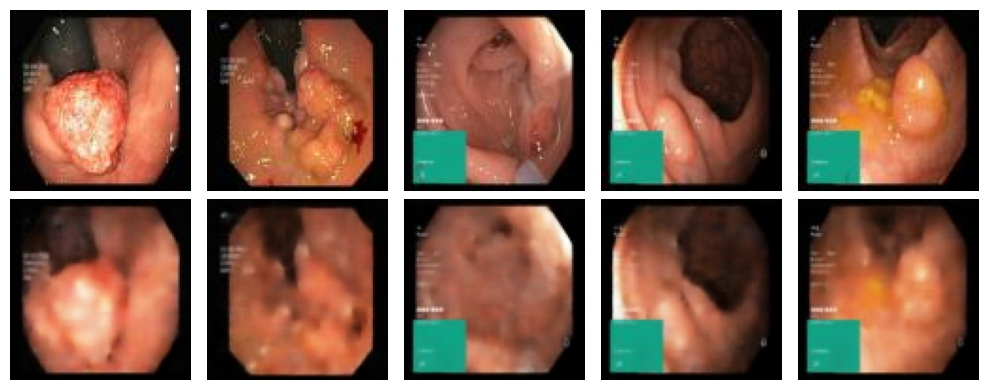

In [22]:
def reconstruct_images(model, image_paths):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    fig, axs = plt.subplots(2, len(image_paths), figsize=(len(image_paths) * 2, 4))
    for i, path in enumerate(image_paths):
        img = Image.open(path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            recon, _, _ = model(input_tensor)
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
        axs[1, i].imshow(recon.squeeze().permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')
    axs[0, 0].set_ylabel("Original")
    axs[1, 0].set_ylabel("Reconstructed")
    plt.tight_layout()
    plt.show()

polyp_paths = random.sample(os.listdir('/content/processed/polyp/imgs'), k=5)
for i in range(len(polyp_paths)):
    polyp_paths[i] = '/content/processed/polyp/imgs/' + polyp_paths[i]
reconstruct_images(model, polyp_paths)


In [20]:
polyp_paths = random.sample(os.listdir('/content/processed/polyp/imgs'), k=50)
for i in range(len(polyp_paths)):
    polyp_paths[i] = '/content/processed/polyp/imgs/' + polyp_paths[i]
evaluate_on_polyp(model, polyp_paths)

Average PSNR: 28.333465454379507
Average SSIM: 0.7932332754135132


***